<a href="https://colab.research.google.com/github/valenciajaime/MN2022_colabs/blob/main/Nuevos/MN2022_1_ODE_ajusteParametros_MJv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada Presentación Clase

**Nombres:** 

Esteban Velilla H.

Jaime A. Valencia V.


**Email:**

esteban.velilla@udea.edu.co

jalejandro.valencia@udea.edu.co


**Curso:**
Métodos numéricos 2022-1

**Fecha:**
Lunes 2022-agosto-01

# Descripción

**Objetivos**

Presentación de la metodologia de ajuste de parametros en una ecuacion diferencial ordinario. Ejemplo del caso de circuito serie RL. Se usa la funcion minimize() de scipy.optimization.


**Desarrollo**



1.   Solucion de EDO usando odeint()
2.   Programacion funcion de Error
3.   Optimizacion de parametros



La imagen muestra la metodologia a seguir para realizar el ajuste de parametros.

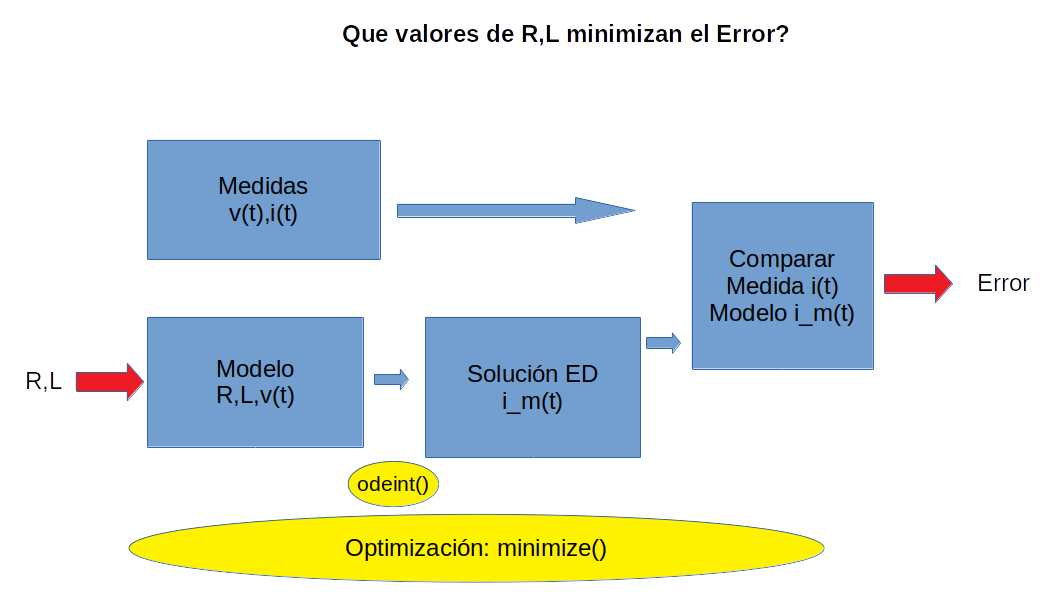

# Modulos principales

Importacion de modulo principales de trabajo en Metodos Numericos.

In [ ]:
import pylab as plt
import matplotlib
import numpy as np
import scipy as SC
import sympy as SP

Observacion de las versiones de los modulos importados.

In [ ]:
print("Version numpy: ",np.__version__)
print("Version Matplotlib: ",matplotlib.__version__)
print("Version scipy: ", SC.__version__)
print("Version sympy: ",  SP.__version__)

Version numpy:  1.21.6
Version Matplotlib:  3.2.2
Version scipy:  1.4.1
Version sympy:  1.7.1


# Solucion de EDO usando odeint()

## programacion funciones

In [ ]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint #funcion para solucion EDO

##funcion de la ecuacion diferencia
def RLserie(y, t, R = 4, L = 0.7, v = lambda x:100 ):
    """y: funcion dependiente de t
    t: variable independiente
    Funcion para solucion de un circuito
    vf = R i + L di/dt
    di/dt = (vf - Ri)/L   esta es la que se programa como
                          funcion de las variables i , t
                          siendo i(t) dependiente de t
    """
    vf = v(t)
    di = (vf - R*y)/L
    return di

##funcion de la fuente de tension
def Fvsin01(t, Amp=20, fq = 60, afi= 60):
    """t: tiempo,   Amp: ampltud; fq:frecuencia en Hz; 
                    afi: angulo desface en grados
       Fueno senoidal con angulo de desface
       vf(t) = amp * cos( 2*pi*fq*t - afi)
    """
    angulo = afi*np.pi/180 #conversion grados a radianes
    wo = 2*np.pi*fq
    v = Amp * np.cos(wo*t - angulo)
    return v


## Solucion EDO

In [ ]:
#Definir parametros
R=5
L=0.7


#definir condicion inicial
Io = 0.0
print('Corriente inicial (cir RL): ', Io)

##definir rango de solucion

t_inicial = 0
t_final= 0.2
T = np.linspace(t_inicial, t_final, 200)

print('Solucion entre ',t_inicial,' y ',t_final, 'segundos')

y_volt = Fvsin01(T)
##Solucionar la ED
y_cor = odeint(RLserie, Io, T,(R,L,Fvsin01))##f(i,t),Condic inic, tiempo,argumetos

print("Len Lista solucion y_cor ",len(y_cor))


Corriente inicial (cir RL):  0.0
Solucion entre  0  y  0.2 segundos
Len Lista solucion y_cor  200


# Lectura de datos(rev 2022-ago-25)

In [ ]:
##Lectura de datos
#Funcion de lectura
def Leer_ADF01(fnombre):
    """fnombre: str nombre de archivo
       Lectura de datos de archivos ADF
       
       retorna un numpy.array con los datos numericos de las
       columnas y los nombres de las columnas.
       Numero de filas== columnas archivo
       Lista de str con nombre de las columnas

    """
    Datos = open(fnombre,"r")
    Datos.readline() #linea de informacion del archivo
    heads = Datos.readline() #Linea de nombre de columnas
    Titulos = heads.strip().split(" ")#separacion nombre de columnas
    Nc = len(Titulos) #numero de columnas

    Valores = []
    for q in Titulos:
      Valores.append([])##abre lista por cada columna
      
    for q in Datos:
      a= q.strip().split('\t')
      for k in range(Nc):
        Valores[k].append(float(a[k]))
    Datos.close()
    Valores = np.array(Valores)
        
    return Valores,Titulos

Datos, etiq = Leer_ADF01("Problema1_MN20221_MJ_P2.adf")
print("Numero datos: ",Datos.shape)

Numero datos:  (3, 300001)


#Grafico Datos leidos

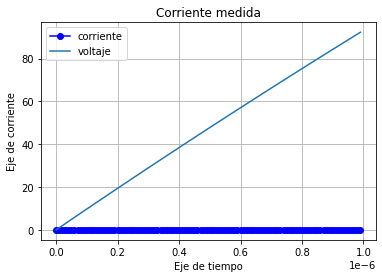

In [ ]:
##si son muchos datos se debe reducir el tamaño
## caso de archivo Problema1_MN20221_MJ_P2.adf
N_init=0
N_fin = 100
T = Datos[0,N_init:N_fin]
y_volt = Datos[1,N_init:N_fin]
y_cor = Datos[2,N_init:N_fin]

plt.plot(T, y_cor, 'bo-',T,y_volt)
plt.title('Corriente medida')
plt.xlabel('Eje de tiempo')
plt.ylabel('Eje de corriente')
plt.legend( ("corriente","voltaje") )
plt.grid(True)
plt.show()

# Problema de optimizacion

Paso1. Crear funcion de error.

Paso2. Minimizar la funcion de error.


Caso sin restriccion
[minimize()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

## Programacion funcion Error

In [ ]:
##funcion Error que calcula la diferencia
## entre los datos y el modelo
## variable : R y L
## datos entrada: v(t), i(t)
## Calculo: error cuadratico promedio

def F_error_edo01(X, D_tiempo, D_voltios, D_amps):
    """X = [R,L] en Ohms y Henrios
       D_tiempo: lista de instantes de tiempo
       D_voltios: Lista de valores de voltaje(t) medidos
       D_amps: Lista de valores de corriente(t) medidos.
       La funcion calcula el error cuadratico medio entre
       el resultado de la solucion de la ecuacion diferencia
       con los parametros R y L y los respectivos valores 
       de la corriente medidos.
    """
    R_in, L_in = X #parametros del circuito que entran
    Io = D_amps[0] # se asume el primer dato del vector de corriente 
                   #  medido
    V_fuente = lambda xx: np.interp(xx,D_tiempo,D_voltios)

    I_modelo = odeint(RLserie, Io, D_tiempo,(R_in,L_in,V_fuente))#Solucion EDO
    ####cambiar########
    ##er1 = (np.array(D_amps)-I_modelo)**2
    ##error = sum(er1)/len(D_tiempo)#Error cuadratico medio
    Suma=0
    NN = len(I_modelo)
    for q in range(NN):
        ei = (I_modelo[q]-D_amps[q])**2
        Suma = Suma + ei
    error = Suma/NN
    
    return error


In [ ]:
#Evaluando la funcion de error
F_error_edo01([5,0.7], T, y_volt, y_cor)

array([1.88381226e-06])

## Comparacion grafica

In [ ]:
##funcion Error que calcula la diferencia
## entre los datos y el modelo
## variable : R y L
## datos entrada: v(t), i(t)
## Calculo: error cuadratico promedio

def F_Show_error_edo01(X, D_tiempo, D_voltios, D_amps):
    """X = [R,L] en Ohms y Henrios
       D_tiempo: lista de instantes de tiempo
       D_voltios: Lista de valores de voltaje(t) medidos
       D_amps: Lista de valores de corriente(t) medidos.
       La funcion calcula el error cuadratico medio entre
       el resultado de la solucion de la ecuacion diferencia
       con los parametros R y L y los respectivos valores 
       de la corriente medidos.
    """
    R_in, L_in = X #parametros del circuito que entran
    Io = D_amps[0] # se asume el primer dato del vector de corriente 
                   #  medido
    V_fuente = lambda xx: np.interp(xx,D_tiempo,D_voltios)

    I_modelo = odeint(RLserie, Io, D_tiempo,(R_in,L_in,V_fuente))#Solucion EDO
    #####cambiar######
    ##er1 = (np.array(D_amps)-I_modelo)**2
    ##error = sum(er1)/len(D_tiempo)#Error cuadratico medio
    Suma=0
    NN = len(I_modelo)
    for q in range(NN):
        ei = (I_modelo[q]-D_amps[q])**2
        Suma = Suma + ei
    error = Suma/NN
    
    print("Error Cuadratico Medio= ",error)
    plt.plot(D_tiempo,D_amps,"ro")
    plt.plot(D_tiempo,I_modelo,"b*-")
    plt.legend(["Datos","Modelo"])
    plt.show()
    return error


Error Cuadratico Medio=  [1.88381226e-06]


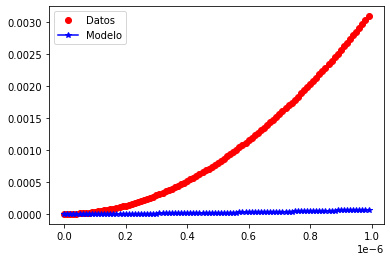

array([1.88381226e-06])

In [ ]:
F_Show_error_edo01([5,0.7], T, y_volt, y_cor)

##Funcion minimize

In [ ]:
from scipy.optimize import minimize

## aplicando un funcion de optimizacion
X0 = [1,1] #vector inicial de busqueda
res = minimize(F_error_edo01,X0,args=(T, y_volt, y_cor),
               method="Powell"),# method='Nelder-Mead')


print("Valores R,L: ",res[0].x)
print("Error minimo: ",res[0].fun)



Valores R,L:  [9.41072938 0.0150002 ]
Error minimo:  9.165488046063054e-18


Error Cuadratico Medio=  [9.16548805e-18]


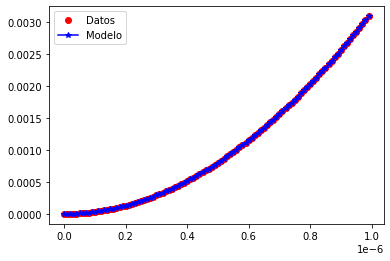

array([9.16548805e-18])

In [ ]:
F_Show_error_edo01(res[0].x, T, y_volt, y_cor)

# Resultados y conclusiones

**Conclusiones:**



**Resultados:**

**Referencias:**



*Libros*

[Numerical Computing with MATLAB
Copyright 2004, Cleve Moler. Introd.](https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/intro.pdf)

[Burde & Faires](https://udeaeduco.sharepoint.com/:b:/s/MtodosNumricos_2022-1/EQd1_32TgMhCh8MBU0FqxpIBSIjxSMEJKAcVIVyvYZHSng?e=nrWw8z)

[Chapra & Canale](https://udeaeduco.sharepoint.com/:b:/s/MtodosNumricos_2022-1/EZgs5MpMDKtLpAZlwGEmn9oB3FvpAGncvlnWPcZ9wRNhIg?e=fPcsyf)





[scipy-interpolate 1.8.1](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html#)  [1.4.1](https://docs.scipy.org/doc/scipy-1.4.1/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)

[2017-marzo-15 Prezi](http://numericalmethodsie20152udea.blogspot.com/2017/03/interpolacion-ajuste-y-procesamieto-de.html)

[Guia Burden y Chapra](http://numericalmethodsie20152udea.blogspot.com/2017/03/documentacion-interpolacion-y-ajuste.html)

[2016-sep-14](http://numericalmethodsie20152udea.blogspot.com/2016/09/ajuste-de-funcion-no-lineal.html)

[2016-sep-7](http://numericalmethodsie20152udea.blogspot.com/2016/09/interpolacion-y-ajuste-de-datos.html)